## Imports

In [1]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd
from numpy import genfromtxt

# Data Split
from sklearn.model_selection import train_test_split

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim

# Evaluation Metrics and Model Selection
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Utility Functions
from itertools import product
import random
from utils import *

In [18]:
df = genfromtxt("data/data_np.csv", delimiter=',')
X = df[:, :18]
y = df[:, 18]

## Data Split



**Improved Generalization through Separate Normalisation**


Normalising the training and validation data separately can improve model generalization in a few ways:

1. **Prevents Data Leakage**: Separately normalising training and validation data prevents information leakage from the validation set into the training process, reducing the risk of overfitting.

2. **Reflects Real-World Variation**: By adapting to the specific characteristics of each dataset, separate normalisation better prepares the model for unseen data with potentially different distributions.

3. **Enhanced Stability**: Separate normalisation ensures that each dataset is scaled appropriately, leading to a more stable training process and better convergence.



In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

### Z-score Normalization

This technique scales the values of a feature to have a mean of 0 and a standard deviation of 1. This is done by subtracting the mean of the feature from each value, and then dividing by the standard deviation.

In [20]:
# Calculate means and standard deviations for the training set
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

X_test_mean = np.mean(X_test, axis=0)
X_test_std = np.std(X_test, axis=0)

X_val_mean = np.mean(X_val, axis=0)
X_val_std = np.std(X_val, axis=0)

# Z-score Normalization of train, validation, and test sets
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_val_mean) / X_val_std
X_test = (X_test - X_test_mean) / X_test_std

### PyTorch tensors

In [21]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)


# Convert to PyTorch tensors
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

## Model Implementation

In [22]:
def create_model(n1, n2,num_features):
    model = nn.Sequential(
        nn.Linear(num_features, n1),
        nn.ReLU(),
        nn.Linear(n1, n2),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(n2, 1),
        nn.Sigmoid()
    )
    return model

### CUDA

In [23]:
param = {'batch_size': 64, 'lr': 0.01, 'n1': 64, 'n2': 32, 'num_ep': 100}#{'batch_size': 64, 'lr': 0.01, 'n1': 32, 'n2': 32, 'num_ep': 150} #{'batch_size': 16, 'lr': 0.01, 'n1': 32, 'n2': 32, 'num_ep': 100}
model = create_model(param["n1"], param['n2'],num_features = 18)
# Define loss function and optimizer
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=param['lr'])

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

## Training

In [24]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

param = {'batch_size': 32, 'lr': 0.001, 'n1': 32, 'n2': 32} #{'batch_size': 32, 'lr': 0.01, 'n1': 64, 'n2': 32}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 100
batch_size = param["batch_size"]

model = create_model(param["n1"], param['n2'],18)
model.to(device)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=param['lr'])

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_precisions = []
val_precisions = []
test_precisions = []
train_recalls = []
val_recalls = []
test_recalls = []
train_f1_scores = []
val_f1_scores = []
test_f1_scores = []

best_val_acc = 0
early_stop_counter = 0
patience = 40  # Number of epochs to wait before early stopping if validation accuracy doesn't improve

for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i + batch_size]
        ybatch = y_train[i:i + batch_size]

        # Forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # Compute training accuracy, precision, recall, and F1 score
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        train_accuracy = (y_pred_train.round() == y_train).float().mean().item()
        train_accuracies.append(train_accuracy)

        train_precision = precision_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_precisions.append(train_precision)

        train_recall = recall_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_recalls.append(train_recall)

        train_f1 = f1_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_f1_scores.append(train_f1)

        # Compute validation loss, accuracy, precision, recall, and F1 score
        y_pred_val = model(X_val)
        val_loss = loss_fn(y_pred_val, y_val)
        val_losses.append(val_loss.item())
        val_accuracy = (y_pred_val.round() == y_val).float().mean().item()
        val_accuracies.append(val_accuracy)

        val_precision = precision_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_precisions.append(val_precision)

        val_recall = recall_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_recalls.append(val_recall)

        val_f1 = f1_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_f1_scores.append(val_f1)

        # Compute test loss, accuracy, precision, recall, and F1 score
        y_pred_test = model(X_test)
        test_loss = loss_fn(y_pred_test, y_test)
        test_losses.append(test_loss.item())
        test_accuracy = (y_pred_test.round() == y_test).float().mean().item()
        test_accuracies.append(test_accuracy)

        test_precision = precision_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_precisions.append(test_precision)

        test_recall = recall_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_recalls.append(test_recall)

        test_f1 = f1_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_f1_scores.append(test_f1)

        # Check for early stopping
        if best_val_acc < val_accuracy:
            best_val_acc = val_accuracy
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} as validation accuracy has not improved for {patience} epochs.')
            break

    print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    if early_stop_counter >= patience:
        break


Epoch [1/100], Train Loss: 0.6363, Val Loss: 0.6864, Test Loss: 0.6853, Train Accuracy: 0.6548, Val Accuracy: 0.5964, Test Accuracy: 0.6000
Epoch [2/100], Train Loss: 0.6065, Val Loss: 0.6622, Test Loss: 0.6597, Train Accuracy: 0.7238, Val Accuracy: 0.6286, Test Accuracy: 0.6800
Epoch [3/100], Train Loss: 0.5825, Val Loss: 0.6382, Test Loss: 0.6343, Train Accuracy: 0.7524, Val Accuracy: 0.6536, Test Accuracy: 0.6767
Epoch [4/100], Train Loss: 0.6096, Val Loss: 0.6139, Test Loss: 0.6076, Train Accuracy: 0.7595, Val Accuracy: 0.6714, Test Accuracy: 0.6900
Epoch [5/100], Train Loss: 0.5752, Val Loss: 0.5909, Test Loss: 0.5820, Train Accuracy: 0.7595, Val Accuracy: 0.6679, Test Accuracy: 0.7033
Epoch [6/100], Train Loss: 0.4026, Val Loss: 0.5725, Test Loss: 0.5603, Train Accuracy: 0.7548, Val Accuracy: 0.6750, Test Accuracy: 0.7133
Epoch [7/100], Train Loss: 0.4725, Val Loss: 0.5608, Test Loss: 0.5462, Train Accuracy: 0.7595, Val Accuracy: 0.6857, Test Accuracy: 0.7233
Epoch [8/100], Train

## Model Performance Evaluation

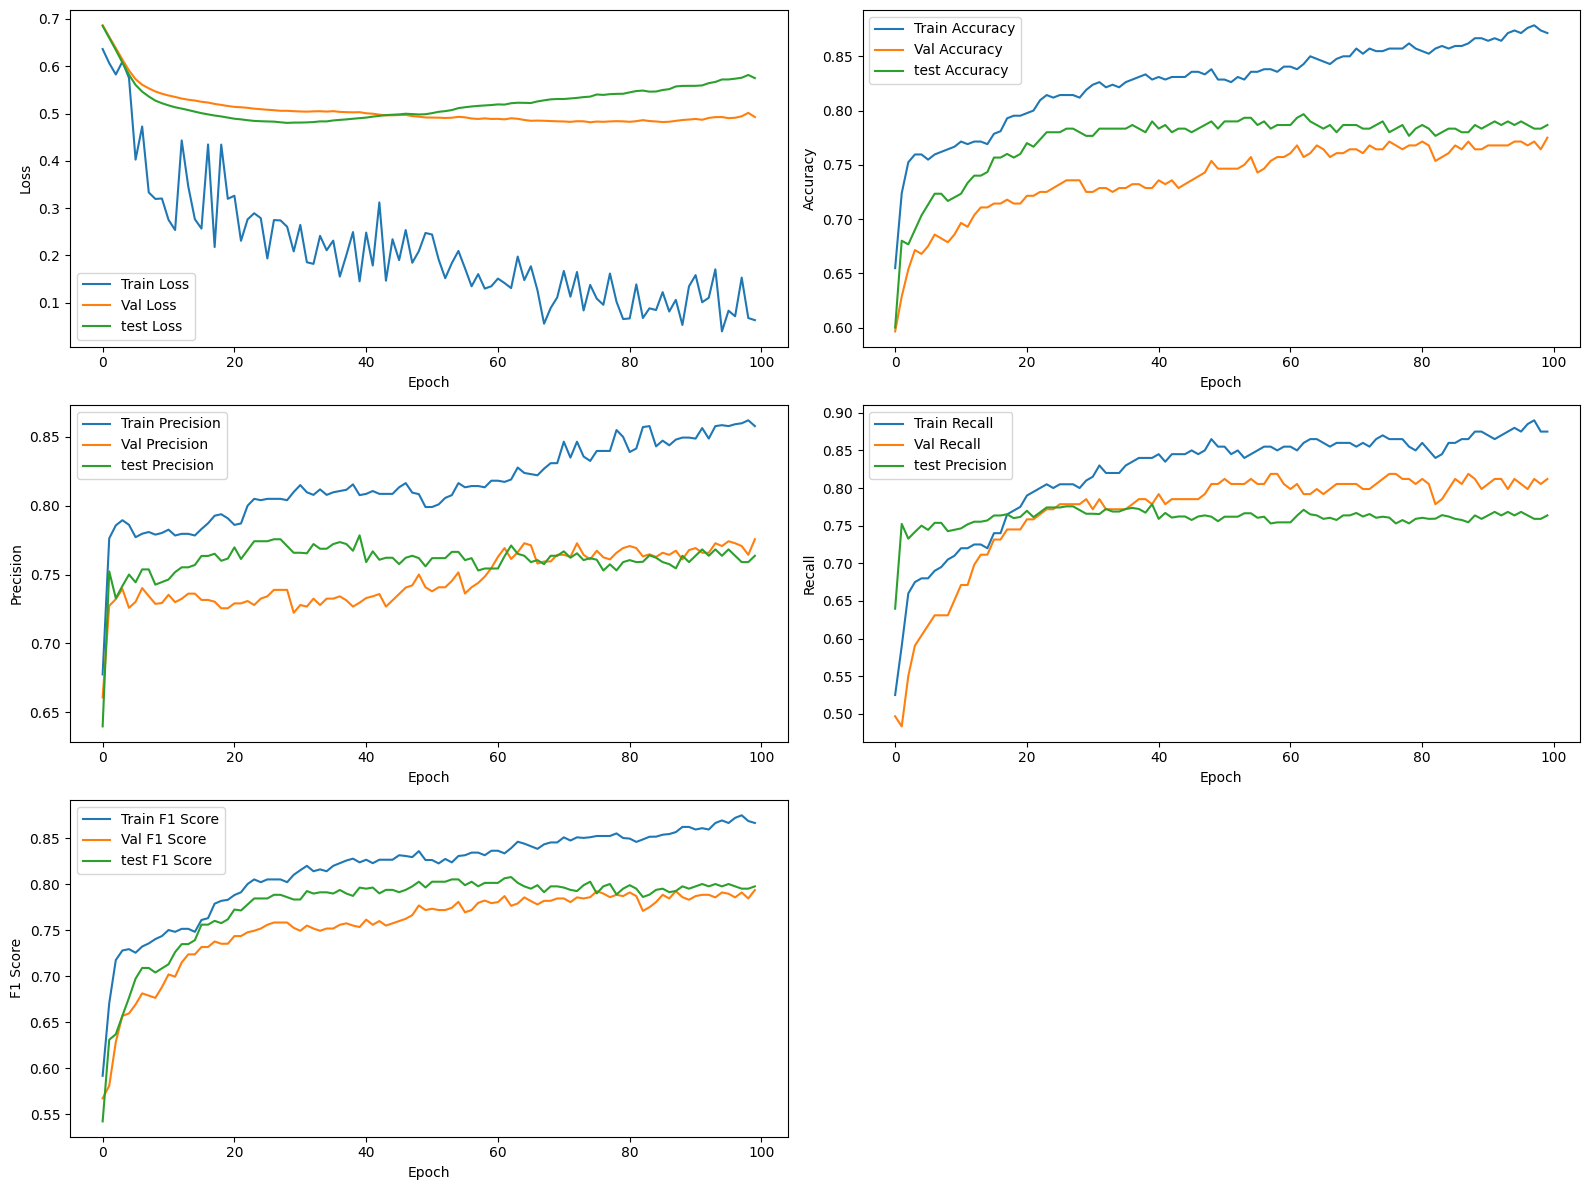

In [18]:
# validation metrics visualisation

plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(train_precisions, label='Train Precision')
plt.plot(val_precisions, label='Val Precision')
plt.plot(test_precisions, label='test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Val Recall')
plt.plot(test_precisions, label='test Precision')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.plot(test_f1_scores, label='test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

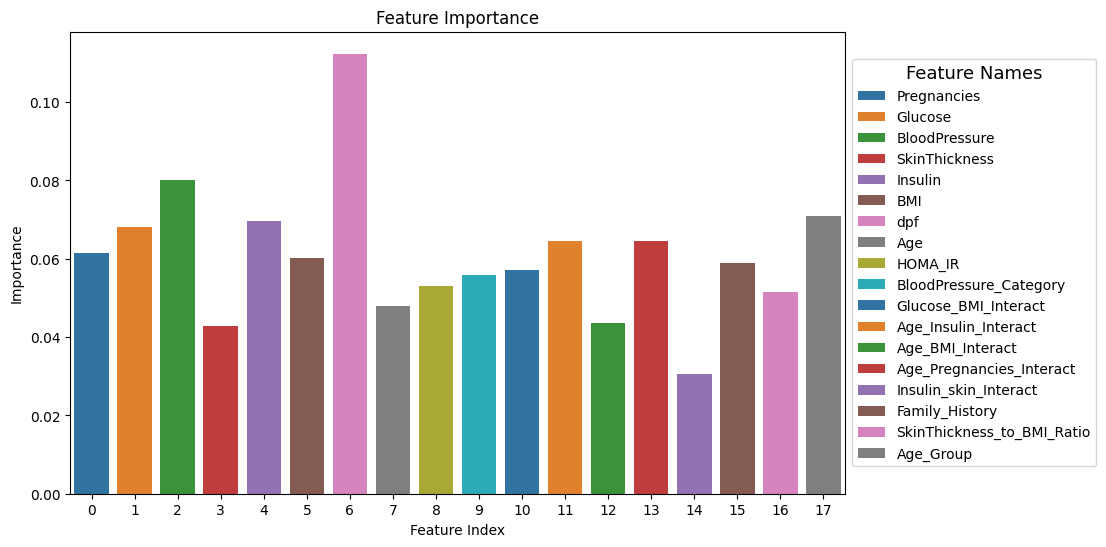

In [12]:

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'HOMA_IR',
       'BloodPressure_Category', 'Glucose_BMI_Interact',
       'Age_Insulin_Interact', 'Age_BMI_Interact', 'Age_Pregnancies_Interact',
       'Insulin_skin_Interact', 'Family_History', 'SkinThickness_to_BMI_Ratio',
       'Age_Group']
data = pd.DataFrame(df,columns=columns)
feature_names = data.columns.drop("Outcome").map(lambda x: "dpf" if x == "DiabetesPedigreeFunction" else x)



# Calculate feature importance
feature_importance = calculate_feature_importance(model, X_train)

# Plot the feature importance with labels
# Assuming 'feature_names' is a list containing the names of the features
colors = sns.color_palette(n_colors=len(feature_importance))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=np.arange(len(feature_importance)), y=feature_importance, palette=colors, hue=feature_names)

# Remove the legend from the plot
ax.legend_.remove()

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Create a legend outside the plot area
plt.legend(title="Feature Names", title_fontsize='13', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()




In [58]:
importance_dict = {'importance':feature_importance,'feature':feature_names}

In [59]:
# Create a dictionary where keys are feature names and values are importance scores
feature_importance_dict = dict(zip(importance_dict['feature'], importance_dict['importance']))

# Sort the dictionary by importance scores in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Select the top features with the highest importance scores
top_features = sorted_features[:10]  # Change 5 to the number of top features you want to select

# Print the top features
print("Top features with highest importance:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")


Top features with highest importance:
dpf: 0.08412777632474899
Glucose: 0.08162439614534378
BloodPressure: 0.06643608212471008
Pregnancies: 0.06272628903388977
Age_Group: 0.06265395134687424
Insulin: 0.055893514305353165
Age_Pregnancies_Interact: 0.05443478375673294
BloodPressure_Category: 0.05071767419576645
Age_Insulin_Interact: 0.046414732933044434
HOMA_IR: 0.04417751729488373


In [60]:
best_features = []
for feature, importance in top_features:
    best_features.append(feature)
print(best_features)

['dpf', 'Glucose', 'BloodPressure', 'Pregnancies', 'Age_Group', 'Insulin', 'Age_Pregnancies_Interact', 'BloodPressure_Category', 'Age_Insulin_Interact', 'HOMA_IR']


In [61]:
best_features.remove("dpf")
best_features.append("DiabetesPedigreeFunction")

In [62]:
X = data[best_features].values
y = data["Outcome"].values

In [63]:

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

param = {'batch_size': 32, 'lr': 0.01, 'n1': 64, 'n2': 32, 'num_ep': 100}

n_epochs = param["num_ep"]
batch_size = param["batch_size"]

model = create_model(param["n1"], param['n2'],18)
model.to(device)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=param['lr'])

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_precisions = []
val_precisions = []
test_precisions = []
train_recalls = []
val_recalls = []
test_recalls = []
train_f1_scores = []
val_f1_scores = []
test_f1_scores = []

best_test_acc = 0
early_stop_counter = 0
patience = 30  # Number of epochs to wait before early stopping if validation accuracy doesn't improve

for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i + batch_size]
        ybatch = y_train[i:i + batch_size]

        # Forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # Compute training accuracy, precision, recall, and F1 score
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        train_accuracy = (y_pred_train.round() == y_train).float().mean().item()
        train_accuracies.append(train_accuracy)

        train_precision = precision_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_precisions.append(train_precision)

        train_recall = recall_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_recalls.append(train_recall)

        train_f1 = f1_score(y_train.cpu().numpy(), y_pred_train.round().cpu().numpy())
        train_f1_scores.append(train_f1)

        # Compute validation loss, accuracy, precision, recall, and F1 score
        y_pred_val = model(X_val)
        val_loss = loss_fn(y_pred_val, y_val)
        val_losses.append(val_loss.item())
        val_accuracy = (y_pred_val.round() == y_val).float().mean().item()
        val_accuracies.append(val_accuracy)

        val_precision = precision_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_precisions.append(val_precision)

        val_recall = recall_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_recalls.append(val_recall)

        val_f1 = f1_score(y_val.cpu().numpy(), y_pred_val.round().cpu().numpy())
        val_f1_scores.append(val_f1)

        # Compute test loss, accuracy, precision, recall, and F1 score
        y_pred_test = model(X_test)
        test_loss = loss_fn(y_pred_test, y_test)
        test_losses.append(test_loss.item())
        test_accuracy = (y_pred_test.round() == y_test).float().mean().item()
        test_accuracies.append(test_accuracy)

        test_precision = precision_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_precisions.append(test_precision)

        test_recall = recall_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_recalls.append(test_recall)

        test_f1 = f1_score(y_test.cpu().numpy(), y_pred_test.round().cpu().numpy())
        test_f1_scores.append(test_f1)

        # Check for early stopping
        if best_test_acc < test_accuracy:
            best_test_acc = test_accuracy
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} as test accuracy has not improved for {patience} epochs.')
            break

    print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    if early_stop_counter >= patience:
        break


Epoch [1/100], Train Loss: 0.3781, Val Loss: 0.5347, Test Loss: 0.5129, Train Accuracy: 0.7738, Val Accuracy: 0.7143, Test Accuracy: 0.7533
Epoch [2/100], Train Loss: 0.3413, Val Loss: 0.5152, Test Loss: 0.5029, Train Accuracy: 0.7810, Val Accuracy: 0.7286, Test Accuracy: 0.7533
Epoch [3/100], Train Loss: 0.2369, Val Loss: 0.5036, Test Loss: 0.4999, Train Accuracy: 0.8048, Val Accuracy: 0.7679, Test Accuracy: 0.7667
Epoch [4/100], Train Loss: 0.2013, Val Loss: 0.5020, Test Loss: 0.5081, Train Accuracy: 0.8024, Val Accuracy: 0.7286, Test Accuracy: 0.7667


Epoch [5/100], Train Loss: 0.1308, Val Loss: 0.4911, Test Loss: 0.4964, Train Accuracy: 0.8167, Val Accuracy: 0.7500, Test Accuracy: 0.7833
Epoch [6/100], Train Loss: 0.3778, Val Loss: 0.5030, Test Loss: 0.5084, Train Accuracy: 0.8167, Val Accuracy: 0.7607, Test Accuracy: 0.7767
Epoch [7/100], Train Loss: 0.2074, Val Loss: 0.4831, Test Loss: 0.5091, Train Accuracy: 0.8310, Val Accuracy: 0.7500, Test Accuracy: 0.7833
Epoch [8/100], Train Loss: 0.1311, Val Loss: 0.5134, Test Loss: 0.5496, Train Accuracy: 0.8429, Val Accuracy: 0.7536, Test Accuracy: 0.7733
Epoch [9/100], Train Loss: 0.2493, Val Loss: 0.4815, Test Loss: 0.5403, Train Accuracy: 0.8429, Val Accuracy: 0.7607, Test Accuracy: 0.7800
Epoch [10/100], Train Loss: 0.0780, Val Loss: 0.4862, Test Loss: 0.5480, Train Accuracy: 0.8333, Val Accuracy: 0.7607, Test Accuracy: 0.7800
Epoch [11/100], Train Loss: 0.0840, Val Loss: 0.4679, Test Loss: 0.5285, Train Accuracy: 0.8357, Val Accuracy: 0.7607, Test Accuracy: 0.7867
Epoch [12/100], Tr

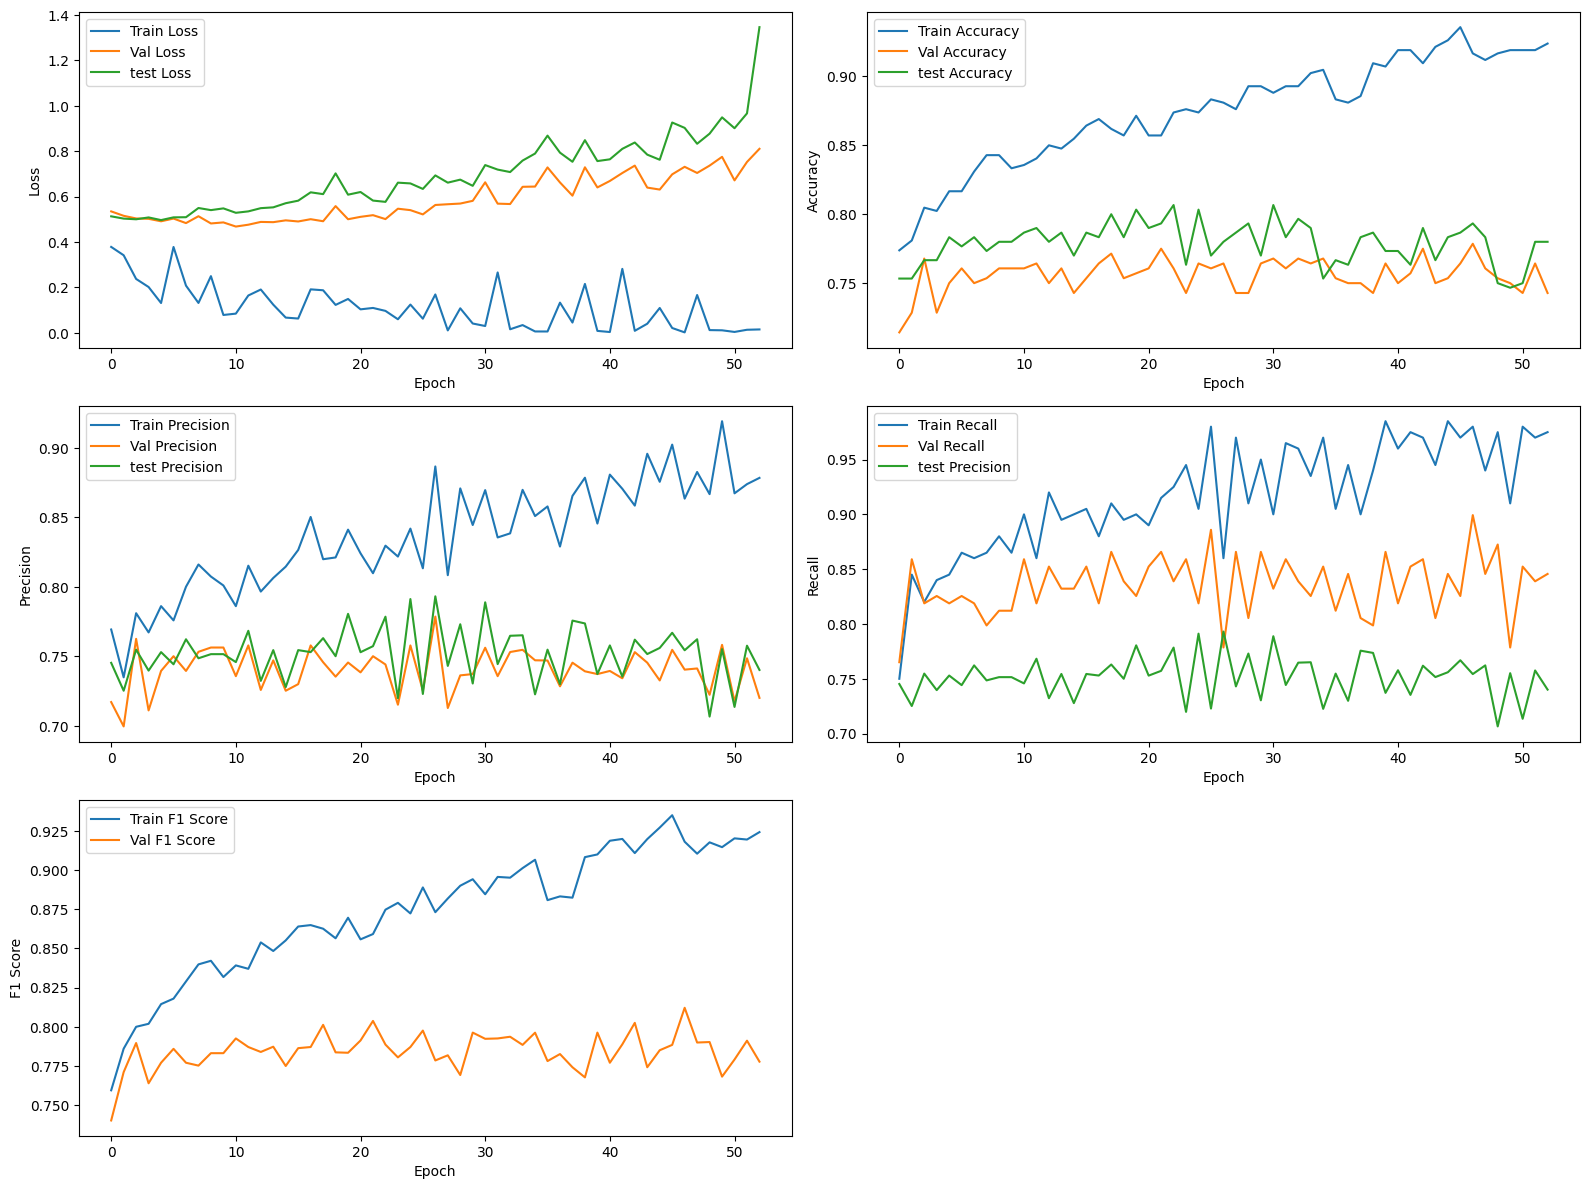

In [64]:
# validation metrics visualisation

plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(test_losses, label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(train_precisions, label='Train Precision')
plt.plot(val_precisions, label='Val Precision')
plt.plot(test_precisions, label='test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Val Recall')
plt.plot(test_precisions, label='test Precision')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Val F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

## Hyper Parameter Tuning

cosine anealing learning rate

In [15]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define the grid search parameters
grid_params = {
    'batch_size': [8,16, 32, 64],
    'lr': [0.001, 0.01, 0.1],
    'n1': [16, 32, 64],
    'n2': [32, 64, 128]
}

best_params = None
best_val_loss = float('inf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop through all combinations of hyperparameters
for params in product(*grid_params.values()):
    param = dict(zip(grid_params.keys(), params))
    model = create_model(param["n1"], param['n2'],18)
    model.to(device)
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=param['lr'])
    n_epochs = 100
    batch_size = param["batch_size"]

    train_losses = []
    val_losses = []

    best_epoch = 0
    best_val_loss = float('inf')
    early_stop_counter = 0
    patience = 20  # Number of epochs to wait before early stopping if validation loss doesn't improve

    for epoch in range(n_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            Xbatch = X_train[i:i + batch_size]
            ybatch = y_train[i:i + batch_size]

            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss = loss_fn(y_pred_val, y_val)
            val_losses.append(val_loss.item())
            y_pred_val = model(X_val)
            val_accuracy = (y_pred_val.round() == y_val).float().mean().item()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch + 1} for parameter combination: {param}')
            break

    print(f'\nParameters: {param}, Best Validation Loss: {best_val_loss:.4f}, Val_acc:{val_accuracy} at epoch {best_epoch + 1}')

    if best_params is None or best_val_loss < best_params['best_val_loss']:
        best_params = {'param': param, 'best_val_loss': best_val_loss}

print("\nBest Parameters:", best_params)



Early stopping at epoch 58 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 32}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 32}, Best Validation Loss: 0.4968, Val_acc:0.7714285850524902 at epoch 38

Early stopping at epoch 70 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 64}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 64}, Best Validation Loss: 0.4811, Val_acc:0.7821428775787354 at epoch 50

Early stopping at epoch 50 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 128}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 16, 'n2': 128}, Best Validation Loss: 0.4863, Val_acc:0.7607142925262451 at epoch 30

Early stopping at epoch 51 for parameter combination: {'batch_size': 8, 'lr': 0.001, 'n1': 32, 'n2': 32}

Parameters: {'batch_size': 8, 'lr': 0.001, 'n1': 32, 'n2': 32}, Best Validation Loss: 0.4835, Val_acc:0.7714285850524902 at epoch 31

Early stopping at epoch 57 for parame

**observations**


Given the small dataset size, it's essential to be cautious about overfitting, as the model might simply be memorizing the training examples rather than learning generalizable patterns. The high validation accuracy of 83.42% is encouraging, indicating that the model performs reasonably well on unseen data, but the significant gap between training and validation accuracies (nearly 13 percentage points) suggests overfitting.

In [65]:
feature_names = df.columns.drop("Outcome")

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

**no Smote**: Best hyperparameters: {'batch_size': 64, 'lr': 0.01, 'n1': 8, 'n2': 8, 'num_ep': 40} Best accuracy: 0.8311688303947449



**with Smote**: 
Best hyperparameters:
{'batch_size': 32, 'lr': 0.01, 'n1': 32, 'n2': 32, 'num_ep': 40}
Best accuracy: 0.8293735980987549


{'batch_size': 64, 'lr': 0.1, 'n1': 32, 'n2': 16, 'num_ep': 50}
Best accuracy: 0.8367875218391418

## next:

1. Feature Selection: Use techniques like correlation analysis, feature importance from tree-based models, or dimensionality reduction methods like PCA to select the most relevant features for your model.

2. Composite Features: Combine multiple related features to create composite features. For example, you can create a feature representing the average blood pressure based on systolic and diastolic measurements.